Fetch arXiv Data

In [811]:
from urllib.request import urlopen
from urllib.parse import urlencode
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from urllib3 import HTTPConnectionPool

import warnings
warnings.filterwarnings('ignore')

In [585]:
def obtaining_raw_data(query, category = 'quant-ph', max_results = 1000):
    arxiv_url = 'http://export.arxiv.org/api/query?'
    
    if isinstance(query, str):
        search_query = query.split() 
    else:
        search_query = query
    search_query = ' AND '.join(search_query)
        
    if search_query == '':
        search_query = 'cat:' + category
    else:
        search_query = 'ti:' + search_query + ' AND cat:' + category
    
    headers = {'search_query':search_query,
           'sortBy':'lastUpdatedDate',
           'sortOrder':'descending',
           'start':0,
           'max_results':max_results}
    
    encoded = urlencode(headers)
    total_url = arxiv_url + encoded
    print('Fetching from '+ total_url)
    html = urlopen(total_url).read()
    html = BeautifulSoup(html)
    entries = html.find_all('entry')
    
    return entries

In [586]:
def generate_df(entries):
    
    ids = [entry.id.contents[0][21:] for entry in entries]
    updated_dates = [entry.updated.contents[0] for entry in entries]
    published_dates = [entry.published.contents[0] for entry in entries]
    titles = [entry.title.contents[0] for entry in entries]
    summaries = [entry.summary.contents[0] for entry in entries]
    authors = [[e.contents[1].contents[0] for e in entry.find_all('author')] for entry in entries]
    
    comments = [entry.find('arxiv:comment') for entry in entries]
    comments = [com.contents[0] if com else com for com in comments]
    
    categories = [[e.attrs['term'] for e in entry.find_all('category')] for entry in entries]
    
    df = pd.DataFrame({'arxiv_id': ids,
                 'updated_date': updated_dates,
                 'published_date': published_dates,
                 'title': titles,
                 'summary': summaries,
                 'authors': authors,
                 'comment': comments,
                 'categories': categories})
    
    return df

In [589]:
def getting_data(query_list, category = 'quant-ph', max_results = 1000):
    
    dfs=[]
    if isinstance(query_list,list):
        queries = query_list
    else:
        queries = [query_list]
        
    if isinstance(category, list):
        categories = category
    else:
        categories = [category]
        
    for query in queries:
        for cat in categories:
            entries = obtaining_raw_data(query, category = cat, max_results = max_results)
            new_df = generate_df(entries)
            dfs.append(new_df)
        
    df = pd.concat(dfs)
    
    df = df.drop_duplicates('arxiv_id')
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    
    print('Totally {} entries'.format(df.shape[0]))
    
    return df
    

In [592]:
def getting_page(comment):
    return _helper(comment, 'page')

def getting_figure(comment):
    return _helper(comment, 'figure')

def _helper(comment, search = 'page'):
    
    if not isinstance(comment, str):
        return None
    
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789+')

    comment = ''.join(filter(whitelist.__contains__, comment))
    comment = comment.lower()
    
    if search not in comment:
        return None
    
    words = comment.split()
    
    if search+'s' in words:
        ind = words.index(search+'s')
        number = words[ind-1]
    elif search in words:
        ind = words.index(search)
        number = words[ind-1]
    else:
        for word in words:
            if search in word:
                ind = word.find(search)
                number = word[:ind]
                break
                    
    if number.isnumeric():
        return int(number)
    if '+' in number:
        nums = number.split('+')
        s=0
        for n in nums:
            if n.isnumeric():
                s += int(n)
            elif n=='':
                continue
            else:
                return None
        return s
    else:
        return None
    
def add_features(df):
    
    df['pages'] = df['comment'].apply(getting_page)
    df['figures'] = df['comment'].apply(getting_figure)
    df['num_of_authors'] = df['authors'].apply(len)
    df['title_length'] = df['title'].apply(lambda s: len(s.split()))
    df['year_of_publish'] = df['published_date'].apply(lambda s: int(s[:4]) )
    df['month_of_publish'] = df['published_date'].apply(lambda s: int(s[5:7]) )
    df['date_of_publish'] = df['published_date'].apply(lambda s: int(s[8:10]))
    
    return df

In [656]:
df = getting_data(['neural network','learning','quantum boltzmann','recognition',], category = ['quant-ph','cond-mat'])

Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Aquant-ph&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Acond-mat&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Alearning+AND+cat%3Aquant-ph&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Alearning+AND+cat%3Acond-mat&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aquantum+AND+boltzmann+AND+cat%3Aquant-ph&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aquantum+AND+boltzmann+AND+cat%3Acond-mat&sortBy=lastUpdatedDate&sortOrder=descending&s

In [657]:
df = add_features(df)

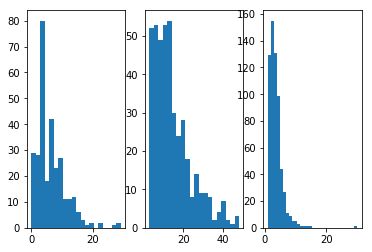

In [670]:
plt.subplot(1,3,1)
plt.hist(df[df.pages<50].figures,bins=20)

plt.subplot(1,3,2)
plt.hist(df[df.pages<50].pages,bins=20)

plt.subplot(1,3,3)
plt.hist(df[df.num_of_authors<50].num_of_authors,bins=30)

In [618]:
def find_prime_authors(df, threshold = 2, ascending=False):
    
    name_list = []
    for authors in df.authors.values:
        for author in authors:
            name_list.append(author)
            
    names = pd.Series(dict(Counter(name_list)))
    names = names[names > threshold]
    
    return names.sort_values(ascending = ascending)


In [683]:
names = find_prime_authors(df, threshold=4)
print(sum(names))
print(len(names))
names.head(10)


188
27


Nathan Wiebe          17
Vedran Dunjko         12
Hans J. Briegel       10
Bassano Vacchini       9
Simone Severini        8
E. C. Behrman          7
J. E. Steck            7
Patrick Rebentrost     7
Jeongho Bang           7
Daoyi Dong             7
dtype: int64

In [652]:
def name_query(df, query):
    return df[df.authors.apply(lambda authors: query.lower() in ''.join(authors).lower())]

In [796]:
name_query(df,'Hans J. Briegel').title

165    Optimizing Quantum Error Correction Codes with...
166    Speeding-up the decision making of a learning ...
177           Advances in Quantum Reinforcement Learning
263    Active learning machine learns to create new q...
288    Machine learning \& artificial intelligence in...
313                    Quantum-enhanced machine learning
323    Quantum machine learning with glow for episodi...
333    Framework for learning agents in quantum envir...
341    Quantum-enhanced deliberation of learning agen...
354           Quantum speedup for active learning agents
Name: title, dtype: object

In [877]:
def getting_citation_by_title(title):
    #url = 'https://scholar.google.com/scholar?hl=en&as_sdt=0%2C47&q=1901.11103&btnG='
    query = '+'.join(title.split())
    url = 'https://scholar.google.com/scholar?hl=en&as_sdt=0%2C47&q='+ query + '&btnG='
    pool = HTTPConnectionPool(url)
    http = urllib3.PoolManager()
    r = http.request('GET', url)
    html=BeautifulSoup(r.data)
    
    entries = html.find_all('div',class_="gs_ri")

    for entry in entries:
        scraped_title = entry.h3.getText()
        text = entry.getText()
        if check_title(scraped_title, title):
            if 'Cited' in text:
                text = text.split()
                indx = text.index('Cited')
                return int(text[indx+2])
            else:
                return 0
    return None

def check_title(title_scraped, title_target):
    t1 = title_scraped.lower()
    t2 = title_target.lower()
    whitelist = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    t1 = ''.join(filter(whitelist.__contains__, t1))
    t2 = ''.join(filter(whitelist.__contains__, t2))
    
    l = min(len(t1),len(t2))
    check_length = l//3
    for i in range(len(check_length)):
        if t1[i]!=t2[i]:
            return False
    return True

In [945]:
def getting_citation_by_arxiv_id(arxiv_id):
    
    query = arxiv_id.split('v')[0]
    url = 'https://scholar.google.com/scholar?hl=en&as_sdt=0%2C47&q='+ query + '&btnG='
    pool = HTTPConnectionPool(url)
    http = urllib3.PoolManager()
    r = http.request('GET', url)
    html=BeautifulSoup(r.data)
    if 'Why did this happen' in html.getText():
        raise Exception('Forbidden')
    entries = html.find_all('div',class_="gs_ri")
    for entry in entries:
        scraped_title = entry.h3.getText()
        text = entry.getText()
        if 'Cited' in text:
                text = text.split()
                indx = text.index('Cited')
                return int(text[indx+2])
    return 0

In [918]:
citations = []
for e, arxiv_id in enumerate(list(df.arxiv_id)):
    print(e, arxiv_id)
    citations.append(getting_citation_by_arxiv_id(arxiv_id))

0 1902.08577v1
1 1902.07006v2
2 1902.05131v1
3 1901.10847v2
4 1808.10601v2
5 1901.10632v1
6 1612.07593v3
7 1901.09133v1
8 1901.07535v2
9 1808.01374v2
10 1807.07445v2
11 1901.02462v1
12 1812.10156v1
13 1812.09329v1
14 1812.08388v2
15 1812.08338v1
16 1812.06693v1
17 1811.12420v3
18 1711.03357v3
19 1901.00731v1
20 1812.03089v1
21 1807.03253v3
22 1811.12456v2
23 1805.05462v2
24 1811.12630v1
25 1811.08893v1
26 1811.07835v1
27 1811.06654v2
28 1810.12948v1
29 1810.10335v1
30 1804.02926v2
31 1810.05025v1
32 1710.03599v3
33 1810.03787v1
34 1807.10300v2
35 1808.10047v2
36 1809.06640v1
37 1809.05519v1
38 1802.05267v3
39 1802.06002v2
40 1808.09058v1
41 1808.05232v1
42 1808.02069v1
43 1804.07633v3
44 1807.03947v1
45 1807.03910v1
46 1807.03325v1
47 1807.00414v1
48 1806.09664v1
49 1806.08781v1
50 1806.07456v1
51 1806.06871v1
52 1806.07251v1
53 1801.09684v2
54 1801.05417v2
55 1806.02747v1
56 1806.06663v1
57 1805.08654v1
58 1710.04713v2
59 1710.09489v3
60 1708.00238v2
61 1802.06441v2
62 1710.08382v2
63

470 1605.00608v1
471 1604.00987v1
472 1405.0298v3
473 1601.02036v1
474 1507.08542v2
475 1503.04216v2
476 1510.04352v1
477 1508.06196v1
478 1508.05820v1
479 1502.00515v2
480 1508.01017v1
481 1507.02642v1
482 1504.03158v1
483 1501.05402v2
484 1503.00700v2
485 1503.04354v1
486 1309.1656v3
487 1212.2576v2
488 1401.0963v5
489 1411.2576v2
490 1410.6854v1
491 1403.7704v2
492 1407.5642v1
493 1407.0362v1
494 1206.5727v2
495 1402.3380v2
496 1405.2825v1
497 1310.7455v2
498 1402.0324v1
499 1402.5116v1
500 1306.0159v2
501 1212.6260v1
502 1202.1301v2
503 1208.4028v1
504 1112.4220v2
505 1206.2707v1
506 1204.3570v1
507 1202.5726v1
508 1111.3306v1
509 1009.5133v2
510 1110.5491v1
511 1107.3008v1
512 1010.4717v2
513 1010.3094v3
514 1101.5517v1
515 1005.0365v2
516 0907.3018v3
517 1009.5345v1
518 1003.2129v2
519 1003.5044v2
520 quant-ph/0112156v6
521 0904.3911v3
522 0901.1453v3
523 0905.3908v1
524 0903.0626v1
525 0807.5072v2
526 cond-mat/0612032v3
527 0806.1947v1
528 0711.3109v2
529 0707.2539v1
530 0707.06

KeyboardInterrupt: 

In [947]:
title = '1712.06863'
query = title
url = 'https://scholar.google.com/scholar?hl=en&as_sdt=0%2C47&q='+ query + '&btnG='
pool = HTTPConnectionPool(url)
http = urllib3.PoolManager()
r = http.request('GET', url)
html=BeautifulSoup(r.data)
    
entries = html.find_all('div',class_="gs_ri")

In [920]:
len(citations)

600

In [921]:
len(df)

623

In [949]:
html.getText()

"\nhttps://scholar.google.com/scholar?hl=en&as_sdt=0%2C47&q=1712.06863&btnG=\n\n\n\n\n\nvar submitCallback = function(response) {document.getElementById('captcha-form').submit();};\n\n\n\n\n\nAbout this pageOur systems have detected unusual traffic from your computer network.  This page checks to see if it's really you sending the requests, and not a robot.  Why did this happen?\n\nThis page appears when Google automatically detects requests coming from your computer network which appear to be in violation of the Terms of Service. The block will expire shortly after those requests stop.  In the meantime, solving the above CAPTCHA will let you continue to use our services.This traffic may have been sent by malicious software, a browser plug-in, or a script that sends automated requests.  If you share your network connection, ask your administrator for help — a different computer using the same IP address may be responsible.  Learn moreSometimes you may be asked to solve the CAPTCHA if y

In [941]:
for e, arxiv_id in enumerate(list(df.arxiv_id)):
    if e<70:
        continue
    print(e, arxiv_id)

70 1802.05710v1
71 1609.05884v2
72 1801.03918v1
73 1710.05367v2
74 1712.05304v1
75 1709.03276v2
76 1711.05238v1
77 1703.05334v2
78 1710.03545v1
79 1705.09334v3
80 1708.06158v1
81 1706.01283v2
82 1701.04844v3
83 1705.00857v1
84 1703.10743v1
85 1512.01141v2
86 1701.05039v1
87 1701.01727v1
88 1601.07137v2
89 1612.01045v1
90 1610.04238v1
91 1609.06935v1
92 1604.00279v2
93 1606.02318v1
94 1503.05125v3
95 1510.00556v2
96 1602.00709v1
97 1601.03277v1
98 1510.09173v2
99 1510.06356v1


In [944]:
raise Exception('spam', 'eggs')

Exception: ('spam', 'eggs')

In [946]:
citations_from_70=[]
for e, arxiv_id in enumerate(list(df.arxiv_id)):
    if e<70:
        continue
    citations_from_70.append(getting_citation_by_arxiv_id(arxiv_id))

Exception: Forbidden

In [951]:
citations[60:70]

[2, 1, 4, 174, 1, 1, 4, 2, 3, 11]

In [952]:
citations[63]

174

In [953]:
df.loc[63]

arxiv_id                                                 1803.11173v1
updated_date                                     2018-03-29T17:39:09Z
published_date                                   2018-03-29T17:39:09Z
title               Barren plateaus in quantum neural network trai...
summary               Many experimental proposals for noisy interm...
authors             [Jarrod R. McClean, Sergio Boixo, Vadim N. Sme...
comment                                                          None
categories                         [quant-ph, cs.LG, physics.chem-ph]
pages                                                             NaN
figures                                                           NaN
num_of_authors                                                      5
title_length                                                        8
year_of_publish                                                  2018
month_of_publish                                                    3
date_of_publish     

In [954]:
citations[0]

0

In [957]:
import seaborn


In [970]:
df.year_of_publish.value_counts().sort_index()

1993      8
1994      7
1995      8
1996     16
1997     12
1998      5
1999     10
2000     13
2001      8
2002     17
2003     10
2004     10
2005      6
2006      7
2007     10
2008      9
2009     15
2010      9
2011     15
2012     16
2013     17
2014     30
2015     35
2016     46
2017     94
2018    165
2019     25
Name: year_of_publish, dtype: int64

In [ ]:
pd.Series.sort_index

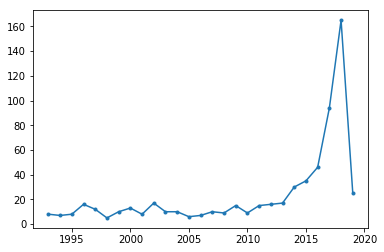

In [971]:
plt.plot(df.year_of_publish.value_counts().sort_index(),'.-')